<a href="https://colab.research.google.com/github/LugoBlogger/MLCC-Assignment-05/blob/master/medical_cost_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we will predict health insurance cost that someone should pay annually by the given features, such as BMI, age, sex, etc.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
# Use tensorflow 2
%tensorflow_version 2.x

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc1


In [0]:
### this library is for callback functions
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Medical Cost Personal Datasets

## Retrieve the dataset

Manage the dataset into pandas' DataFrame.

In [6]:
dataset = pd.read_csv("https://raw.githubusercontent.com/LugoBlogger/MLCC-Assignment-05/master/datasets/insurance.csv", header=0)
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


The data consists of several columns:

**age**: age of primary beneficiary

**sex**: insurance contractor gender, female, male

**bmi**: Body Mass Index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m^2) using the ratio of height to weight, ideally 18.5 to 24.9

**children**: Number of children covered by health insurance / Number of dependents

**smoker**: whether or not the beneficiary smokes

**region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**charges**: Individual medical costs billed by health insurance

## Exploratory Data Analysis

Some features have categorical data while the others are continuous data. The categorical ones include sex, smoker and region. The rest, which are age, bmi, children and charges are continuous data.
We would like to see the correlation between each of these features.
Thus, we will encode categorical features to convert them into continuous values.

In [0]:
from sklearn.preprocessing import LabelEncoder

data = dataset

le = LabelEncoder()

#sex
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)

# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)

#region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)


Now, the all the data are continous. We can make correlations to see how each feature correlate to our target prediction, which is charges.

In [8]:
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

In statistics, correlation or dependence is any statistical relationship, whether causal or not, between two random variables or bivariate data. In the broadest sense correlation is any statistical association, though it commonly refers to the degree to which a pair of variables are linearly related.

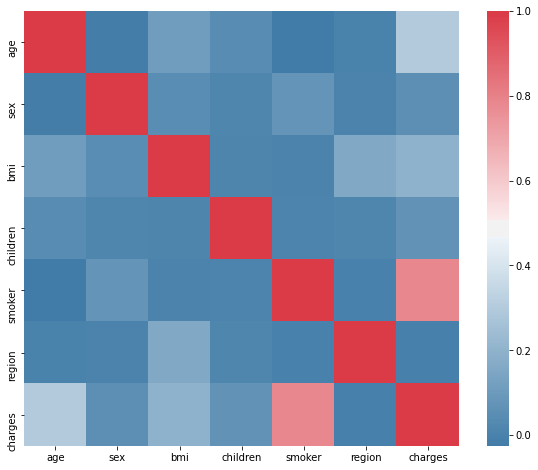

In [9]:
import matplotlib.pyplot as pl

f, ax = pl.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(240,10,as_cmap=True),square=True, ax=ax)

A strong correlation is observed between smoker and charges and it is a positive correlation. It means that if someone smokes, the cost of health insurance will be higher as compared to those who do not smoke.

On the other hand, we observe another interesting thing here, which is BMI. We can consider BMI as the indicator of how healthy someone is, according to their body weight and height. Thus, we might have expected that BMI would have strong correlations to health insurance cost/charges. However, the data shows that it is not.

Since smoker feature has a strong correlation with charges. Let's investigate more on this.

Let's see the distribution charges for those who smoke and those who do not smoke.

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

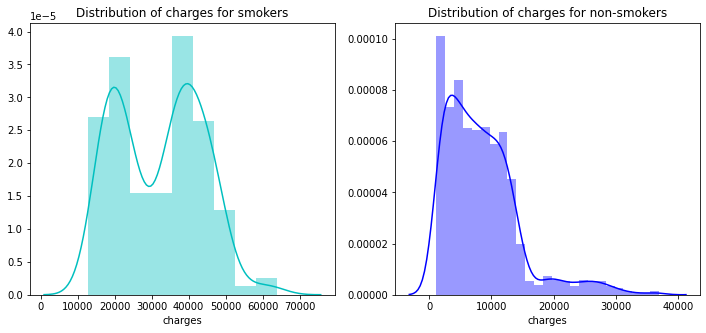

In [10]:
f= pl.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

The distribution of charges for smokers and non-smokers above show that smokers will be charged more as compared to those who do not smoke. However, let's see how many of these people actually smoke.

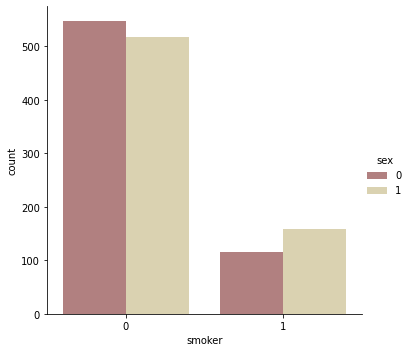

In [11]:
sns.catplot(x="smoker", kind="count",hue ='sex', palette="pink", data=data)

The x axis shows "0" for non-smokers and "1" as smokers. The graph shows that there are more non-smokers than smokers. The graph also compared if the people are women or men, whereas women are coded as symbol "1" and men as "0". We can notice that there are more male smokers than women smokers.

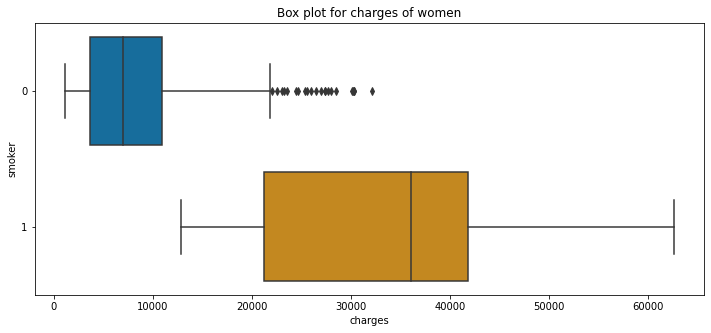

In [12]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 1)] , orient="h", palette = 'colorblind')

It is clear that smokers have higher range is charges as compared to the non-smokers.

Next, the second strongest correlated of feature towards charges is age. Let's investigate more on this in our dataset.

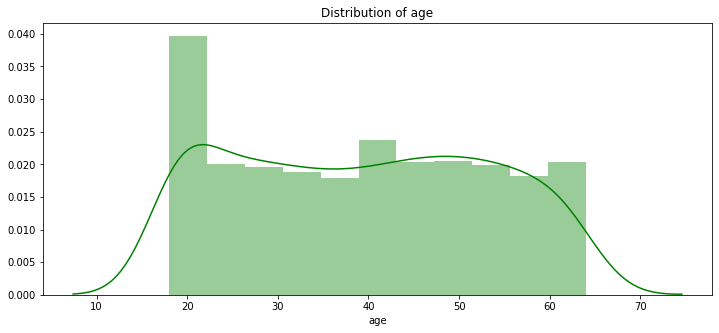

In [13]:
pl.figure(figsize=(12,5))
pl.title("Distribution of age")
ax = sns.distplot(data["age"], color = 'g')

Text(0.5, 1.0, 'Distribution of charges and age for non-smokers')

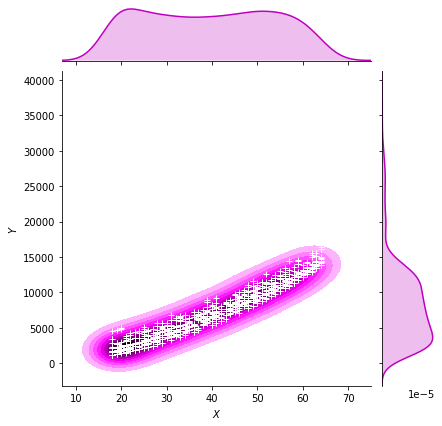

In [14]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 0)],kind="kde", color="m")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for non-smokers')

Text(0.5, 1.0, 'Distribution of charges and age for smokers')

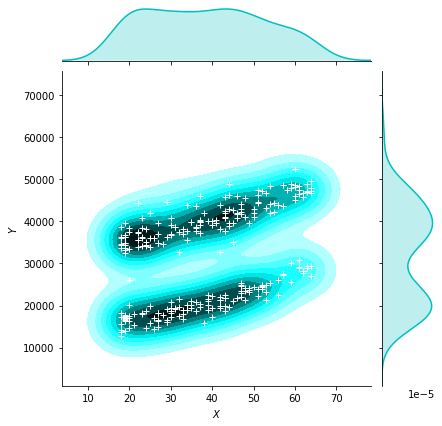

In [15]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 1)],kind="kde", color="c")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for smokers')

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Smokers and non-smokers')

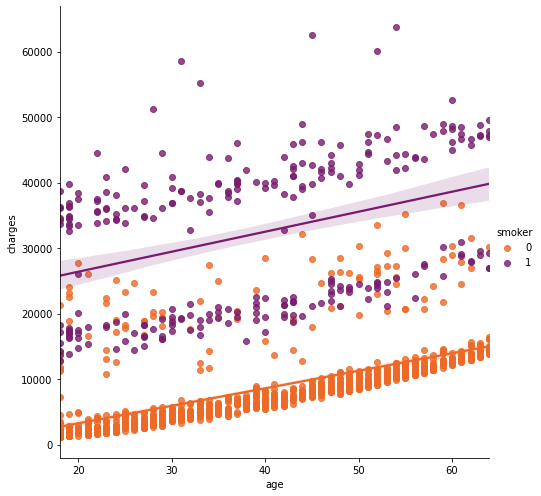

In [16]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
ax.set_title('Smokers and non-smokers')

It can be observed that for non-smokers, the cost of treatment increases with age. However, for smoking people, we do not observe such dependence. I think that it is not only in smoking but also in the peculiarities of the dataset. Such a strong effect of smoking on the cost of treatment would be more logical to judge having a set of data with a large number of records and signs.

Next, let's observe about BMI, eventhough it has relatively weak correlation with charges.

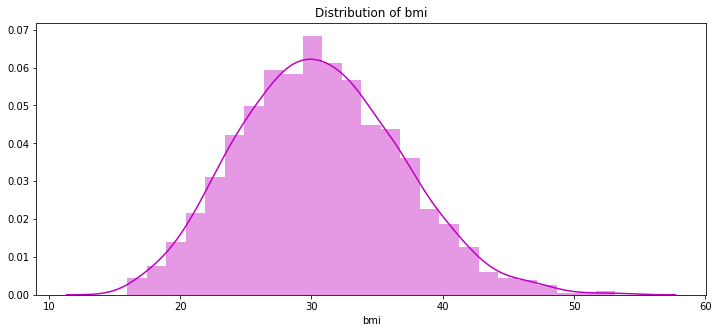

In [17]:
pl.figure(figsize=(12,5))
pl.title("Distribution of bmi")
ax = sns.distplot(data["bmi"], color = 'm')

It appears that the average US citizens who are the beneficiary of health insurance have BMI of 30, whereas the ideal BMI is 18.5 to 24.9 BMI of 30 indicates obesity. Now, let's see the distribution of charges in people with BMI above 30 and less than 30.

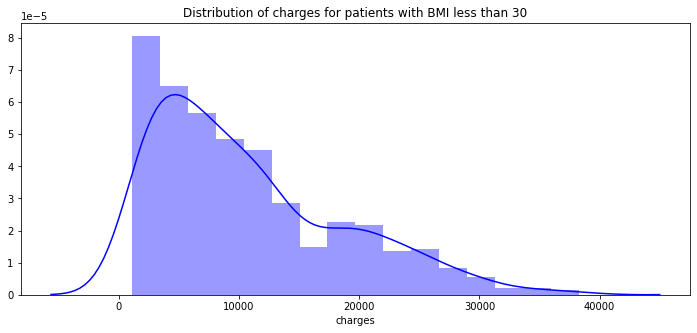

In [18]:
pl.figure(figsize=(12,5))
pl.title("Distribution of charges for patients with BMI less than 30")
ax = sns.distplot(data[(data.bmi < 30)]['charges'], color = 'b')

People who have BMI above 30 are charged more with their health insurance as compared to those people with BMI less than 30. It appears that eventhough BMI does not have strong correlation with the charges, severe obesity can make people pay more for their medical bills. Well, obese people tend to be more susceptible towards illnesses.

Now, let's observe if we compare smoker, bmi and charges.

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


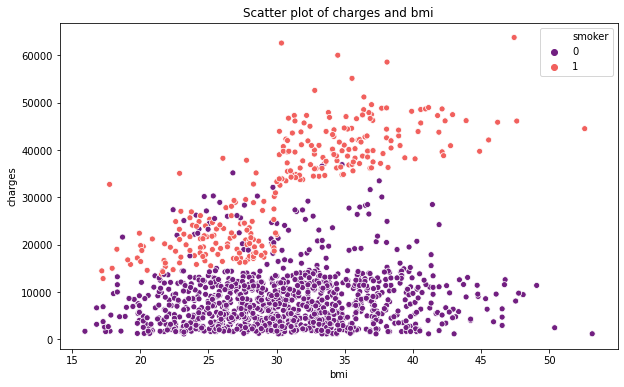

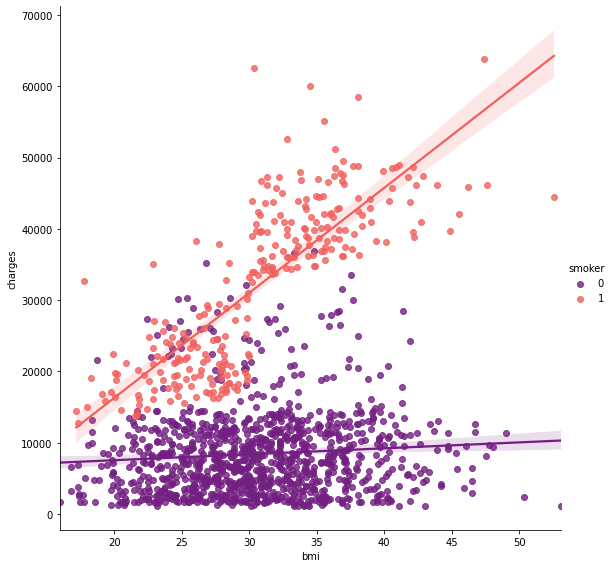

In [19]:
pl.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='smoker')
ax.set_title('Scatter plot of charges and bmi')

sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'magma', size = 8)

It appears that for non smokers, the increase of bmi does not really affect the increase of charges. However, for those who smoke, the increase of bmi indicates higher charges. That means, a smoker who is obese will have a really high amount of health insurance cost.

## Clean the data

Checking the dataset whether is clean or not.

In [0]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Convert categorical columns into numeric with the following convention:

* `sex`: male = 1, female = 2,

* `smoker`: yes = 1, no = 0,

* `region`: northeast = $\displaystyle\frac{\pi}{4}$, northwest = $\displaystyle\frac{3\pi}{4}$, southwest = $\displaystyle\frac{5\pi}{4}$, southeast = $\displaystyle\frac{7\pi}{4}$. We use the representation of direction by their angle on unit circle. If we compute the method `.mean`, it will make a sense (where is the region whose citizens are the most recorded).

In [0]:
dataset.loc[dataset['sex'] == 'male', 'sex'] = 1
dataset.loc[dataset['sex'] == 'female', 'sex'] = 2

dataset.loc[dataset['smoker'] == 'yes', 'smoker'] = 1
dataset.loc[dataset['smoker'] == 'no', 'smoker'] = 0

dataset.loc[dataset['region'] == 'northeast', 'region'] = np.pi/4
dataset.loc[dataset['region'] == 'northwest', 'region'] = 3*np.pi/4
dataset.loc[dataset['region'] == 'southwest', 'region'] = 5*np.pi/4
dataset.loc[dataset['region'] == 'southeast', 'region'] = 7*np.pi/4

dataset['region'] = pd.to_numeric(dataset['region'])

dataset

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.900,0,1,3.926991,16884.92400
1,18,1,33.770,1,0,5.497787,1725.55230
2,28,1,33.000,3,0,5.497787,4449.46200
3,33,1,22.705,0,0,2.356194,21984.47061
4,32,1,28.880,0,0,2.356194,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2.356194,10600.54830
1334,18,2,31.920,0,0,0.785398,2205.98080
1335,18,2,36.850,0,0,5.497787,1629.83350
1336,21,2,25.800,0,0,3.926991,2007.94500


## Split the data into a training set and a test set.

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=2020)
test_dataset = dataset.drop(train_dataset.index)

N_train = len(train_dataset)
N_test = len(test_dataset)
print('N_train:', N_train)
print('N_test:', N_test)
print('N_train/N_dataset:', N_train/len(dataset))

N_train: 1070
N_test: 268
N_train/N_dataset: 0.7997010463378177


## Inspect the data

We look at the joint distribution of a few pairs of columns from the training set. The diagonal elements represent kerned density estimation (kde) for univariate variables for given columns. We include all the columns to inspect which variable has a correlation to another variable

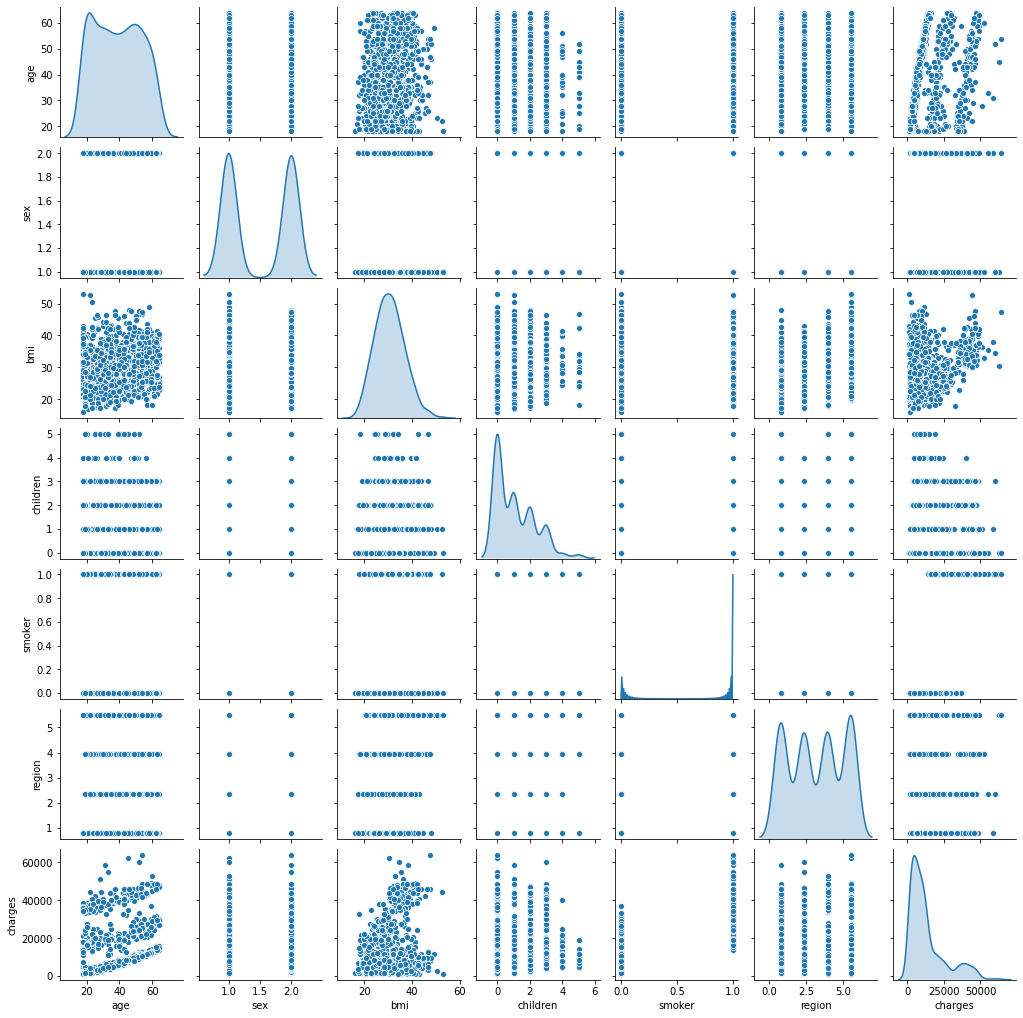

In [0]:
sns.pairplot(train_dataset[['age', 'sex', 'bmi', 'children', 'smoker', 
                            'region', 'charges']], 
             diag_kind='kde', height=2);

In [0]:
train_dataset

,age,sex,bmi,children,smoker,region,charges
1293,46,1,25.745,3,0,2.356194,9301.89355
361,35,1,30.500,1,0,3.926991,4751.07000
802,21,1,22.300,1,0,3.926991,2103.08000
623,18,1,33.535,0,1,0.785398,34617.84065
735,49,2,34.770,1,0,2.356194,9583.89330
...,...,...,...,...,...,...,...
979,36,2,29.920,0,0,5.497787,4889.03680
162,54,1,39.600,1,0,3.926991,10450.55200
171,49,1,30.300,0,0,3.926991,8116.68000
265,46,1,42.350,3,1,5.497787,46151.12450


If we look at the above table, we see that BMI and charges have an intriguing pattern.

We also inspect at their statistical description:

In [0]:
train_stats = train_dataset.describe()
train_stats.pop('charges')

# for pretty output
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,1070.0,38.943925,14.062091,18.000000,26.000000,39.000000,51.000000,64.000000
sex,1070.0,1.495327,0.500212,1.000000,1.000000,1.000000,2.000000,2.000000
bmi,1070.0,30.696785,6.157567,15.960000,26.237500,30.400000,34.700000,53.130000
children,1070.0,1.080374,1.206890,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1070.0,0.203738,0.402965,0.000000,0.000000,0.000000,0.000000,1.000000
region,1070.0,3.182698,1.799384,0.785398,0.785398,3.926991,5.497787,5.497787


### Split features from labels

Separate the target value, or "label", from features. In this case, we assume our target value is `charges`.

In [0]:
# Remember that .pop method will extract the value not the labels!

train_labels = train_dataset.pop('charges')
test_labels = test_dataset.pop('charges')

In [0]:
test_labels

0       16884.92400
6        8240.58960
7        7281.50560
24       6203.90175
29      38711.00000
           ...     
1305     2464.61880
1306    16115.30450
1327     9377.90470
1331    10795.93733
1332    11411.68500
Name: charges, Length: 268, dtype: float64

### Normalize the data

In [0]:
def normalize(x_val):
    return (x_val - train_stats['mean']) / train_stats['std']

normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)

In [0]:
normed_train_data

,age,sex,bmi,children,smoker,region
1293,0.501780,-0.990234,-0.804179,1.590556,-0.505598,-0.459326
361,-0.280465,-0.990234,-0.031958,-0.066596,-0.505598,0.413638
802,-1.276050,-0.990234,-1.363653,-0.066596,-0.505598,0.413638
623,-1.489389,-0.990234,0.460931,-0.895172,1.976007,-1.332289
735,0.715119,1.008918,0.661497,-0.066596,-0.505598,-0.459326
...,...,...,...,...,...,...
979,-0.209352,1.008918,-0.126151,-0.895172,-0.505598,1.286601
162,1.070685,-0.990234,1.445898,-0.066596,-0.505598,0.413638
171,0.715119,-0.990234,-0.064439,-0.895172,-0.505598,0.413638
265,0.501780,-0.990234,1.892503,1.590556,1.976007,1.286601


## Regression model

### Construct the model

In this model we use the model with two densely connected hidden layars (`layer.Dense(64)`), and an output layer that returns a single continous value (`layer.Dense(1)`).

In [0]:
train_dataset.keys()

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [0]:
# relu = rectifier linear unit activation function
# The first argument of RMSprop algorithm is learning rate.
# You can check the creator of RMSprop (Root Mean Square propagation) in 
# his lecture. Hinton is known as a "Godfather of AI"
# https://www.youtube.com/watch?v=XhZahXzEuNo

# mse and mae are metrics
# mse = mean squared error
# mae = mean absoulte error

def construct_model():
    reg_model = keras.Sequential([
        layers.Dense(64, activation='relu', 
                     input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(.001)

    reg_model.compile(loss='mse', optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return reg_model

In [0]:
reg_model = construct_model()

### Inspect the regression model

In [0]:
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


Now we try out the regression model by taking a batch of 5 samples from the training data and call `reg_model.predict()`.

> **Note**
>
>In offline platform, we have to cast the format of `normed_train_data` into numpy array.

In [0]:
example_batch = normed_train_data[:5]
example_result = reg_model.predict(example_batch)
example_result

array([[-0.33743232],
       [-0.15567961],
       [-0.3412    ],
       [-0.44432744],
       [-0.00998501]], dtype=float32)

Quick check on the shape and data type shows that the regression model seems to be working. 

### Train the regression model

We will train the regression model for 2000 epochs, and record the training and validation accuracy in the `history` object.

> **Note**
>
>In offline platform, we have to cast the format of `normed_train_data` and `train_label` into numpy array.


In [0]:
EPOCHS = 4000

# the validation_split will split for the data for validation
# from the last samples of normed_train_data. This smaller
# splitted data will be used in the validation process.

start_compute = time.time()

history = reg_model.fit(
    normed_train_data, train_labels, epochs=EPOCHS,
    validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()]
)

print('Approximation computational time: {:.2f} s'.format(time.time() 
                                                         - start_compute))


Epoch: 0, loss:328287425.7944,  mae:13307.9336,  mse:328287392.0000,  val_loss:323582397.9065,  val_mae:12969.2461,  val_mse:323582400.0000,  
....................................................................................................
Epoch: 100, loss:34385614.2804,  mae:3895.6562,  mse:34385616.0000,  val_loss:30368397.3458,  val_mae:3667.2400,  val_mse:30368400.0000,  
....................................................................................................
Epoch: 200, loss:31212977.5327,  mae:3586.3752,  mse:31212978.0000,  val_loss:28467005.7850,  val_mae:3474.4321,  val_mse:28467006.0000,  
....................................................................................................
Epoch: 300, loss:27162034.5421,  mae:3136.7605,  mse:27162034.0000,  val_loss:25866958.2430,  val_mae:3163.5667,  val_mse:25866960.0000,  
....................................................................................................
Epoch: 400, loss:24536018.6168,  ma

We visualize the regression model's training progress using the progress that stored in the `history` object.

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
3995,1.585593e+07,2172.849121,15855931.0,2.043693e+07,2506.919678,20436928.0,3995
3996,1.586093e+07,2175.238281,15860937.0,2.044698e+07,2523.964844,20446984.0,3996
3997,1.584793e+07,2183.042969,15847924.0,2.046164e+07,2531.564209,20461640.0,3997
3998,1.585962e+07,2178.803711,15859617.0,2.045297e+07,2529.616455,20452974.0,3998
3999,1.584975e+07,2194.208008,15849754.0,2.043116e+07,2509.615967,20431160.0,3999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

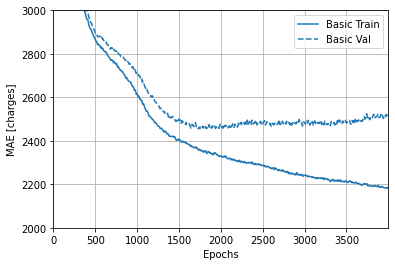

In [0]:
plotter.plot({'Basic': history}, metric='mae')
plt.ylim([2e3, 3e3])
plt.ylabel('MAE [charges]');

Text(0, 0.5, 'MSE [charges^2]')

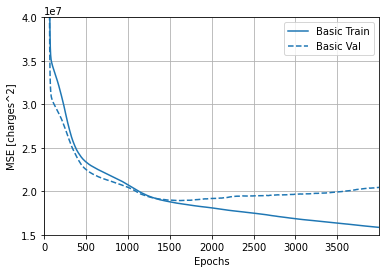

In [0]:
plotter.plot({'Basic': history}, metric='mse')
plt.ylim([1.5e7, 4e7])
plt.ylabel('MSE [charges^2]')

In the graphs above, we can notice that there is a little decreasing on the long run of epochs. Since we are constrained by time. We conclude that 
MSE might not be converge. From two metrics above we also easily notice that their value is really big numbers even though we have normalize the datasets.

The next step, we want to see how well that regression model generalizes the `test` set.

> **Note**
>
>Sometimes, we have to cast the format of `normed_test_data` and `test_label` into numpy array. The correct procure is
>
> `x_array = np.asarray(x_list)`



In [0]:
normed_test_data_np_arr = np.asarray(normed_test_data, dtype=float)
test_labels_np_arr = np.asarray(test_labels, dtype=float)

loss, mae, mse = reg_model.evaluate(normed_test_data_np_arr, test_labels_np_arr, 
                                    verbose=2)

print("Testing set Mean Abs Error: {:5.2f} (charges)".format(mae))

268/268 - 0s - loss: 23027157.4254 - mae: 2711.8274 - mse: 23027156.0000
Testing set Mean Abs Error: 2711.83 (charges)


### Make prediction

Finally, we predict the charges of medical cost using data in the testing set.

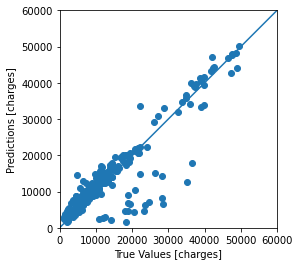

In [0]:
test_predictions = reg_model.predict(normed_test_data_np_arr).flatten()

a = plt.axes(aspect='equal')

plt.scatter(test_labels, test_predictions)

plt.xlabel('True Values [charges]')
plt.ylabel('Predictions [charges]')
lims = [0, 6e4]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

We see on the graph there are some points are not align with the diagonal line. It means the regression model has a big error on predicting that data.

The next step is taking an inspection at the error distribution.

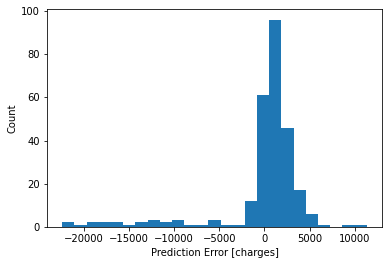

In [0]:
error = test_predictions - test_labels

plt.hist(error, bins=25)
plt.xlabel('Prediction Error [charges]')
_ = plt.ylabel('Count')

This error is not quite gaussian, because our number of data is relatively small.

## Conclusion